In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
import random
from sklearn.metrics import f1_score, precision_score, recall_score, median_absolute_error, mean_absolute_error,mean_squared_error

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm
from tqdm.notebook import tqdm_notebook

import transformers
from transformers import AutoModel, AutoTokenizer
from transformers.models.bert import modeling_bert

In [13]:
# Function to map hexbin plot colors
def my_reduce(x):
    npsum = np.sum(x)
    return np.log(npsum)


# Function to train model (1 epoch)
def train_model(model,input_function, train_loader, criterion, optimizer, verbose = False):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.train() # enable train mode
    running_loss = 0.0
    
    if verbose == 2:
        status = train_loader
    else:
        status = tqdm_notebook(train_loader, 0)
        
    for i, data in enumerate(status):
        # get the inputs; data is a tuple of lists [inputs, labels]
        inputs, labels = data
        input_tensors = input_function(inputs)
        labels =  labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = model(*input_tensors)
        loss = criterion(torch.squeeze(outputs).to(torch.float32),labels.to(torch.float32))
        loss.backward()
        optimizer.step()

        # print statistics
        if verbose !=2:
            running_loss += loss.item()
            if i % 500 == 499:    # print every 500 batches
                tqdm.write(f'Batch {i + 1:5d}    Loss: {running_loss / 500:.5f}')
                running_loss = 0.0

                
# Function to test model            
def test_model(model,input_function, test_loader, criterion, verbose = False):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.eval() # enable evaluation mode
    valid_loss = 0
    valid_preds, valid_labels = [], []
    
    if verbose == 2:
        status = test_loader
    else:
        status = tqdm_notebook(test_loader, 0)
        
    for i, data in enumerate(status):
        # get the inputs; data is a tuple of lists: [inputs, labels]
        inputs, labels = data
        input_tensors = input_function(inputs)
        labels =  labels.to(device)
        
        outputs = model(*input_tensors)
        loss = criterion(outputs[0].to(torch.float32),labels.to(torch.float32))
        valid_preds.append(outputs[0].cpu().detach().item())
        valid_labels.append(labels.cpu().detach().item())
        valid_loss += loss.item()

    valid_mse = mean_squared_error(valid_labels, valid_preds)
    valid_maerr = mean_absolute_error(valid_labels, valid_preds)
    
    if verbose !=2:
        print("\nTest Results:\nLoss: {:.6f}".format(valid_loss / len(test_loader)))
        print("Total Mean Squared Error: {:.4f}".format(valid_mse))
        print("Total Mean Absolute Error: {:.4f}\n".format(valid_maerr))

        # Plots

        # Prepare Hexbin plot
        temp_df = pd.DataFrame(zip(valid_preds,valid_labels), columns = ['Predicted values', 'Hops'])
        temp_df['Hops'] = 1/temp_df['Hops']
        temp_df['C'] = 1

        if verbose:
            fig, axes = plt.subplots(4,1, figsize = (10,20))
        else:
            fig, axes = plt.subplots(2,1, figsize = (10,10))

        temp_df.plot.hexbin(ax = axes[0], x ='Hops', y='Predicted values',C = 'C', reduce_C_function=my_reduce,colormap="viridis")
        axes[0].set_title("Hexbin Plot")
    
    # Calculate metrics per Hop
    mse = []
    mae = []
    high1_p=high_close_p=high_mid_p=high_far_p=high1_n=high_close_n=high_mid_n=high_far_n=0
    for i in range(1,30):
        target = 1/i
#         target = i
        preds = []
        trues = []
        for predicted, true in zip(valid_preds, valid_labels):
            if true == target:
                preds.append(predicted)
                trues.append(true)
                if predicted > 0.9:
                    if i==1:
                        high1_p +=1
                    elif i<4:
                        high_close_p +=1
                    elif i<11:
                        high_mid_p +=1
                    else:
                        high_far_p +=1
                else:
                    if i==1:
                        high1_n +=1
                    elif i<4:
                        high_close_n +=1
                    elif i<11:
                        high_mid_n +=1
                    else:
                        high_far_n +=1
        if len(trues)==0:
            continue
        mae.append(mean_absolute_error(trues, preds))
        mse.append(mean_squared_error(trues, preds))
        if i<4 and verbose != 2:
            print(" Hop '"+str(i)+"'\tMAE: {:.4f}, MSE: {:.4f}".format(mae[i-1],mse[i-1])) 
        if i==1:
            hist_preds = preds
    if high1_n == 0: high1_n=1
    if high_close_n == 0: high_close_n=1
    if high_mid_n == 0: high_mid_n=1
    if high_far_n == 0: high_far_n=1
    p1 = high1_p*100/(high1_p+high1_n)
    p2 = high_close_p*100/(high_close_p+high_close_n)
    p3 = high_mid_p*100/(high_mid_p+high_mid_n)
    p4 = high_far_p*100/(high_far_p+high_far_n)
    tp = high1_p
    tn = high_mid_n + high_far_n
    fp = high_mid_p + high_far_p
    fn = high1_n
    if fp == 0: fp = 1
    pseudo_precision = tp/(tp + fp)
    pseudo_recall = tp/(tp + fn)
    pseudo_accuracy = (tp + tn) / (tp + fn + tn +fp)
    if pseudo_recall == 0 and pseudo_precision == 0 :
        pseudo_f1 = 0
        f1g = 0
    else:
        pseudo_f1 = 2 * pseudo_precision * pseudo_recall / (pseudo_precision + pseudo_recall)
        proportion = (high1_n + high1_p)/(high_mid_p + high_mid_n + high_far_p + high_far_n)
        f1g = (pseudo_f1 - proportion)/(pseudo_f1 * (1 - proportion))
    
    if verbose !=2:
        print("\nPercentage of prediction > 0.9: ")
        print(" Hop  1: \t{:.4f}%".format(p1))
        print(" Hops 2-3: \t{:.4f}%".format(p2))
        print(" Hops 4-10: \t{:.4f}%".format(p3))
        print(" Hops 11+: \t{:.4f}%".format(p4))
        
        print("\nPseudo binary metrics (ignoring Hops 2 & 3): ")
        print("Precision: \t{:.4f}%".format(pseudo_precision*100))
        print("Recall: \t{:.4f}%".format(pseudo_recall*100))
        print("Accuracy: \t{:.4f}%".format(pseudo_accuracy*100))
        print("f1: \t{:.4f}%".format(pseudo_f1*100))
        print("f1 Gain: \t{:.4f}%".format(f1g*100))
    
        if high1_n>1:
            sns.histplot(hist_preds,ax = axes[1], color = 'lime')
        axes[1].set_title("Prediction distribution for Hop '1'")
        axes[1].grid(axis = 'y', alpha = 0.5)

        if verbose:
            axes[2].bar(range(1,len(mse)+1), mse, color = 'lightcoral')
            axes[2].set_title("Mean Squared Error per Hop")
            axes[2].grid(axis = 'y', alpha = 0.5)
            for i, v in enumerate(mse):
                axes[2].text(i+0.9 , 0.01, str(round(v,4)), color='black',fontsize = 8, fontweight='bold', rotation = 90)

            axes[3].bar(range(1,len(mae)+1), mae, color = 'royalblue')
            axes[3].set_title("Mean Absolute Error per Hop")
            axes[3].grid(axis = 'y', alpha = 0.5)
            for i, v in enumerate(mae):
                axes[3].text(i+0.9 , 0.01, str(round(v,4)), color='black',fontsize = 8, fontweight='bold', rotation = 90)
        plt.show()
   
    return {'pseudo_precision': pseudo_precision, 'pseudo_recall':pseudo_recall, 'pseudo_accuracy': pseudo_accuracy, 'pseudo_f1': pseudo_f1 ,'mse_list': mse, 'mae_list': mae, "Hop1 High": p1,'Hop2-3 High%': p2, 'Hop4-10 High%': p3, 'Hop11+ High%': p4, 'loss':(valid_loss / len(test_loader))}


def save_for_best_mse1(metrics_dict):
    return metrics_dict['mse_list'][0]

# Function to train model and test model for multiple epochs
def AIO(model, input_function, train_loader, valid_loader, EPOCHS, criterion, optimizer, scheduler,save_name, save_criterion_func = save_for_best_mse1, train_loader2 = None, verbose = False):
    try:
        os.mkdir('./'+save_name+'/') 
    except:
        if verbose != 2:
            print("Couldn't make new directory "+save_name+ ", it already exists?")
    
    # Initialize best save criterion value
    best_save_criterion = 100000000
    last_epoch = 0
    
    # Use GPU
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    
    # Start training
    for epoch in range(1, EPOCHS+1):  # loop over the dataset multiple times
        if verbose != 2: tqdm.write("Epoch "+str(epoch))
            
        # Train
        train_model(model,input_function, train_loader, criterion, optimizer, verbose)
        
        # If subsampled train set is provided, test to monitor overfitting behaviour
        if train_loader2 is not None:
            test_model(model, input_function, train_loader2, criterion, verbose)
            
        # Test on validation dataset   
        valid_metrics = test_model(model, input_function, valid_loader, criterion, verbose)
        scheduler.step()
        
        # If validation performance is better, save model
        save_criterion = save_criterion_func(valid_metrics)
        if save_criterion < best_save_criterion:
            best_save_criterion = save_criterion
            last_epoch = epoch
            torch.save(model, save_name+'/Model.pth')
            # If the model uses a tokenizer as input, save it
            try:
                input_function.save_pretrained(save_name+'/custom_tokenizer/') 
            except:
                pass
            if verbose != 2:
                print("New best Validation! Saving weights...")
                
    if verbose == 2:
        return valid_metrics['loss'], last_epoch
    print('Finished Training')
    return valid_metrics['loss'], last_epoch

In [14]:
def inverse_transform(Hops):
    return (1/Hops)


def joining(text1, text2):
    text = text1
    text += f" [SEP] "+text2
    return text


def Load_Datasets(Dataset_version,y_transform = inverse_transform, Max_Hops_Samples_relativeToHop1 = 1.1, ValidationPercentageSplit = 0.1, SubTrainPercentage = 0.1, verbose = True):
    # Load whole Train dataset
    data_train = pd.read_csv('Hops Dataset '+Dataset_version+' - A.csv', header=0)
    data_train = data_train[data_train["Hops"]>0]

    # Load whole Test dataset
    data_test = pd.read_csv('Hops Dataset '+Dataset_version+' - B.csv', header=0)
    data_test = data_test[data_test["Hops"]>0]

    # Balanced (subsampled) datasets
    data_train_balanced = data_train.groupby('Hops', group_keys=False).apply(
        lambda x: x.sample(min(len(x), round(len(data_train[data_train['Hops']==1])*Max_Hops_Samples_relativeToHop1))))

    data_test_balanced = data_test.groupby('Hops', group_keys=False).apply(
        lambda x: x.sample(min(len(x), round(len(data_test[data_test['Hops']==1])*Max_Hops_Samples_relativeToHop1))))

    # Validation Dataset. Initialize from data
    data_valid = data_test.groupby('Hops', group_keys=False).apply(
        lambda x: x.sample(min(len(x), round(len(data_test_balanced[data_test_balanced['Hops']==1])*ValidationPercentageSplit))))
    # Remove any entry given to the validation set from the balanced test set
    data_test = data_test[~data_test.isin(data_valid)].dropna()

    # Subsampled train set to monitor overfitting behaviour
    data_sub_train = data_train_balanced.groupby('Hops', group_keys=False).apply(
        lambda x: x.sample(min(len(x), round(len(data_train_balanced[data_train_balanced['Hops']==1])*SubTrainPercentage))))

    if verbose: 
        fig, axes = plt.subplots(1,2, figsize = (25,10), sharey = True, sharex = True)
        all_sns_bins = list(range(1,25))
        print("Raw Train data: "+str(data_train.shape[0])+" samples")
        sns.histplot(data_train["Hops"],ax = axes[0], bins = all_sns_bins)
        axes[0].set_title("Raw Train data: "+str(data_train.shape[0])+" samples")
        print("Raw Test data: "+str(data_test.shape[0])+" samples")
        sns.histplot(data_test["Hops"],ax = axes[1], bins = all_sns_bins)
        axes[1].set_title("Raw Test data: "+str(data_test.shape[0])+" samples")
        plt.show()

        fig, axes = plt.subplots(1,3, figsize = (25,10), sharey = True, sharex = True)
        print("Balanced Train data: "+str(data_train_balanced.shape[0])+" samples")
        sns.histplot(data_train_balanced["Hops"],ax = axes[0], bins = all_sns_bins)
        axes[0].set_title("Balanced Train data: "+str(data_train_balanced.shape[0])+" samples")
        print("Validation data: "+str(data_valid.shape[0])+" samples")
        sns.histplot(data_valid["Hops"],ax = axes[1], bins = all_sns_bins)
        axes[1].set_title("Validation data: "+str(data_valid.shape[0])+" samples")
        sns.histplot(data_test_balanced["Hops"],ax = axes[2], bins = all_sns_bins)
        axes[2].set_title("Balanced Test data - no overlap: "+str(data_test_balanced.shape[0])+" samples")
        plt.show()

    data_train_balanced["Hops"] = y_transform(data_train_balanced["Hops"])
    if verbose: print(data_train_balanced)
    y_train = pd.to_numeric(data_train_balanced.Hops)#.astype(int)
    x_train = np.vectorize(joining)(data_train_balanced.Head.astype(str),data_train_balanced.Tail.astype(str))
    if verbose: print(x_train[0])
        
    data_valid["Hops"] = y_transform(data_valid["Hops"])
    y_valid = pd.to_numeric(data_valid.Hops)#.astype(int)
    x_valid = np.vectorize(joining)(data_valid.Head.astype(str),data_valid.Tail.astype(str))

    data_sub_train["Hops"] = y_transform(data_sub_train["Hops"])
    y_sub_train = pd.to_numeric(data_sub_train.Hops)#.astype(int)
    x_sub_train = np.vectorize(joining)(data_sub_train.Head.astype(str),data_sub_train.Tail.astype(str))

    data_test_balanced["Hops"] = y_transform(data_test_balanced["Hops"])
    y_test_balanced = pd.to_numeric(data_test_balanced.Hops)#.astype(int)
    x_test_balanced = np.vectorize(joining)(data_test_balanced.Head.astype(str),data_test_balanced.Tail.astype(str))
    
    return x_train,y_train,x_valid,y_valid,x_sub_train,y_sub_train,x_test_balanced,y_test_balanced

In [18]:
# Test f1 anf f1 Gain for different random predistions

positive = 1
negative = 11.04
proportion = positive/negative
prob = 1
recall = prob
precision = positive/(negative+positive)
f1 = (2*precision*recall)/(precision+recall)
f1 = 0.713464
f1G = (f1-proportion)/(f1*(1-proportion))
print(f1)
print(f1G)

0.713464
0.9599987634539713


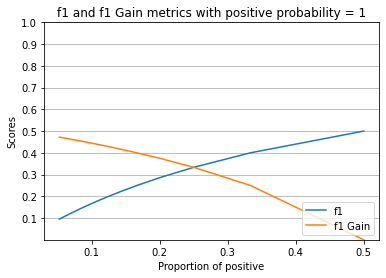

In [5]:
negs = np.array(range(2,20))
positive = 1
probability = 1
recall = probability
f1s = []
f1Gs = []
props = []
for neg in negs:
    proportion = positive/neg
    props.append(proportion)
    precision = positive/(neg+positive)
    f1 = (2*precision*recall)/(precision+recall)
    f1s.append(f1)
    f1Gs.append((f1-proportion)/(f1*(1-proportion)))

plt.plot(props, f1s, color ='tab:blue') 
plt.plot(props, f1Gs, color ='tab:orange') 
     
plt.ylim([0, 1]) 
plt.grid(axis = 'y')
plt.yticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
plt.title('f1 and f1 Gain metrics with positive probability = '+str(probability)) 
plt.xlabel('Proportion of positive')
plt.ylabel('Scores')
plt.legend(["f1", "f1 Gain"], loc ="lower right")    
plt.show()

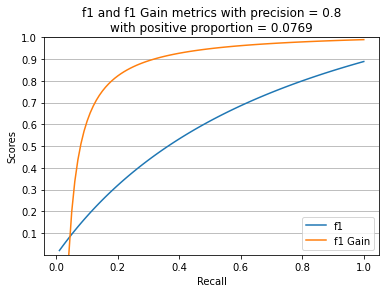

In [6]:
recs = np.array(range(1,101))
recs = recs/100

positive = 1
negative = 13
proportion = positive/negative
precision = 0.8

f1s = []
f1Gs = []

for rec in recs:
    recall = rec
    f1 = (2*precision*recall)/(precision+recall)
    f1s.append(f1)
    f1Gs.append((f1-proportion)/(f1*(1-proportion)))

plt.plot(recs, f1s, color ='tab:blue') 
plt.plot(recs, f1Gs, color ='tab:orange') 
     
plt.ylim([0, 1]) 
plt.grid(axis = 'y')
plt.yticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
plt.title('f1 and f1 Gain metrics with precision = '+str(precision)+'\nwith positive proportion = '+str(round(proportion,4))) 
plt.xlabel('Recall')
plt.ylabel('Scores')
plt.legend(["f1", "f1 Gain"], loc ="lower right")    
plt.show()

Raw Train data: 2027091 samples
Raw Test data: 3902132 samples


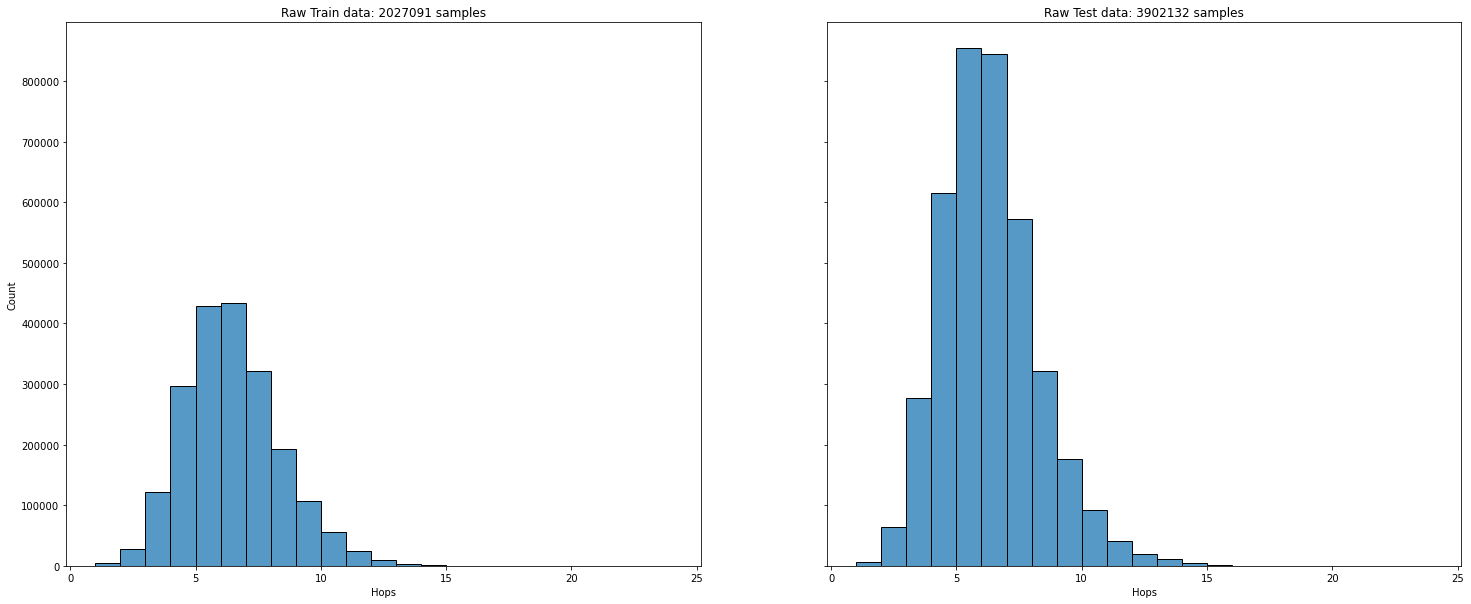

Balanced Train data: 54739 samples
Validation data: 5278 samples


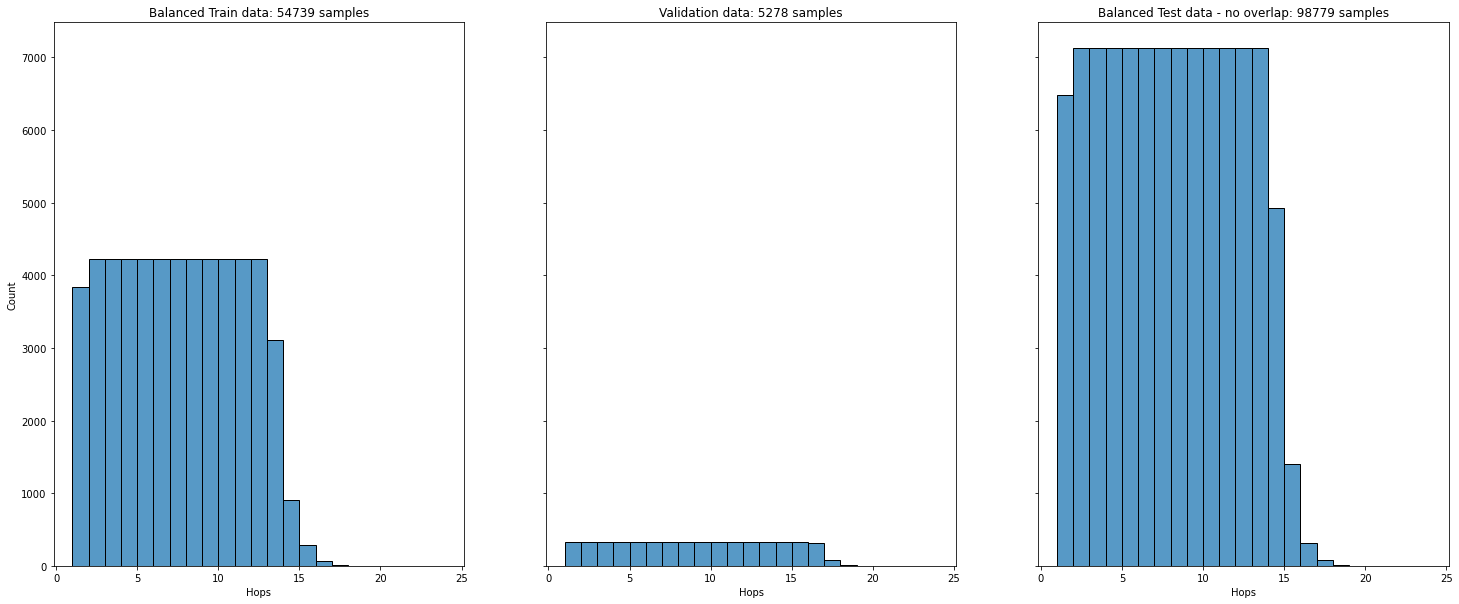

                                                  Head  \
637168                          16alpha-Hydroxyestrone   
1563433                         CTNNB1, catenin beta 1   
1286735     7-Hydroxymethyl-12-methylbenz[a]anthracene   
1070701                                        8,9-EET   
1717451                             IL3, interleukin 3   
...                                                ...   
828681      MOGS, mannosyl-oligosaccharide glucosidase   
828094                  (Glc)2 (GlcNAc)2 (Man)9 (Asn)1   
829643      MOGS, mannosyl-oligosaccharide glucosidase   
854291                   Dolichyl D-glucosyl phosphate   
832738   ALG10B, ALG10 alpha-1,2-glucosyltransferase B   

                                                      Tail      Hops  
637168   CYP3A4, cytochrome P450 family 3 subfamily A m...  1.000000  
1563433                       TCF3, transcription factor 3  1.000000  
1286735       SULT2A1, sulfotransferase family 2A member 1  1.000000  
1070701            

In [7]:
def squared(Hops):
    return Hops**2

def no_transform(Hops):
    return Hops

def make_binary(Hops):
    temp = 1/Hops
    return np.floor(temp)
    

y_transform = inverse_transform
# y_transform = make_binary
x_train,y_train,x_valid,y_valid,x_sub_train,y_sub_train,x_test_balanced,y_test_balanced = Load_Datasets(
     'v8',y_transform = y_transform, Max_Hops_Samples_relativeToHop1 = 1.1, ValidationPercentageSplit = 0.05, SubTrainPercentage = 0.05)

In [8]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
def FE_inputs(inputs_list):
    input_embeddings = []
    for row in inputs_list:
        X_ls = row.split(' [SEP] ')
        input_embeddings.append(np.append(embeddings_dict[X_ls[0]],embeddings_dict[X_ls[1]]))
    return torch.FloatTensor(np.array(input_embeddings)).to(DEVICE)


class random_model():
    def __init__(self, function):
        self.function = function
        self.eval = self.__eval__
        
    def __eval__(self):
        pass
    
    def __call__(self, *args):
        return torch.Tensor([self.function()])
    
    
def my_loss(output, target):
    loss = torch.mean(((output - target)**2)*(target+0.01/target)) # More attention to low hops
    return loss

criterion = my_loss

# Load Embeddings Dictionary  
import pickle
with open('node_embeddings_dict.pkl', 'rb') as f:
    embeddings_dict = pickle.load(f)

Test random models on balanced test set - no common nodes with train set

Random Uniform distribution 0-1


  0%|          | 0/98779 [00:00<?, ?it/s]


Test Results:
Loss: 0.066347
Total Mean Squared Error: 0.2137
Total Mean Absolute Error: 0.3803

 Hop '1'	MAE: 0.4983, MSE: 0.3328
 Hop '2'	MAE: 0.2498, MSE: 0.0831
 Hop '3'	MAE: 0.2748, MSE: 0.1096

Percentage of prediction > 0.9: 
 Hop  1: 	10.1990%
 Hops 2-3: 	9.4894%
 Hops 4-10: 	10.1417%
 Hops 11+: 	10.2641%

Pseudo binary metrics (ignoring Hops 2 & 3): 
Precision: 	7.6771%
Recall: 	10.1990%
Accuracy: 	83.7094%
f1: 	8.7602%
f1 Gain: 	5.6702%


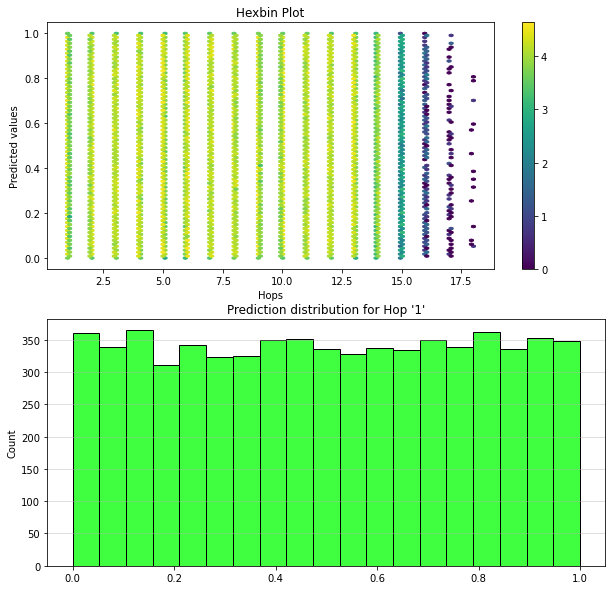


Random Gauss distribution m=0.5 std=0.2


  0%|          | 0/98779 [00:00<?, ?it/s]


Test Results:
Loss: 0.052540
Total Mean Squared Error: 0.1684
Total Mean Absolute Error: 0.3564

 Hop '1'	MAE: 0.4959, MSE: 0.2843
 Hop '2'	MAE: 0.1593, MSE: 0.0402
 Hop '3'	MAE: 0.2099, MSE: 0.0666

Percentage of prediction > 0.9: 
 Hop  1: 	2.2373%
 Hops 2-3: 	2.3776%
 Hops 4-10: 	2.2624%
 Hops 11+: 	2.3350%

Pseudo binary metrics (ignoring Hops 2 & 3): 
Precision: 	7.5091%
Recall: 	2.2373%
Accuracy: 	90.3906%
f1: 	3.4475%
f1 Gain: 	-153.6546%


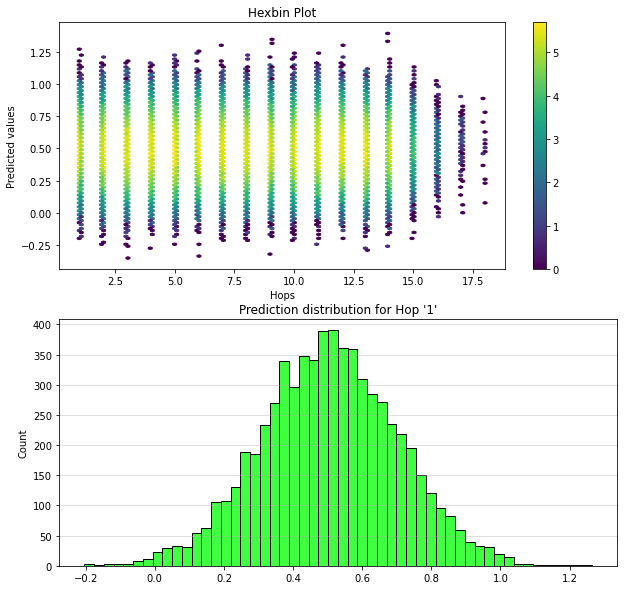


Random Gauss distribution m=0.3 std=0.1


  0%|          | 0/98779 [00:00<?, ?it/s]


Test Results:
Loss: 0.042234
Total Mean Squared Error: 0.0705
Total Mean Absolute Error: 0.2075

 Hop '1'	MAE: 0.6988, MSE: 0.4985
 Hop '2'	MAE: 0.2010, MSE: 0.0498
 Hop '3'	MAE: 0.0835, MSE: 0.0110

Percentage of prediction > 0.9: 
 Hop  1: 	0.0000%
 Hops 2-3: 	0.0000%
 Hops 4-10: 	0.0000%
 Hops 11+: 	0.0000%

Pseudo binary metrics (ignoring Hops 2 & 3): 
Precision: 	0.0000%
Recall: 	0.0000%
Accuracy: 	92.3310%
f1: 	0.0000%
f1 Gain: 	0.0000%


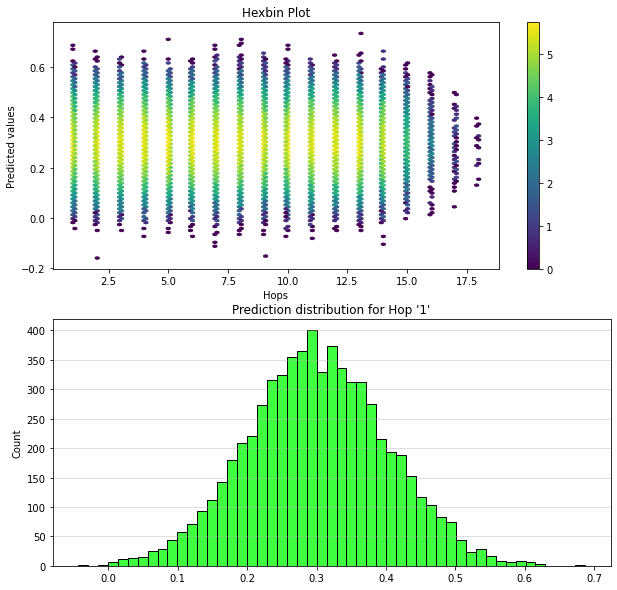

{'pseudo_precision': 0.0,
 'pseudo_recall': 0.0,
 'pseudo_accuracy': 0.9233099074797094,
 'pseudo_f1': 0,
 'mse_list': [0.4984577014677686,
  0.04984918958478588,
  0.010968231855076673,
  0.012868537303683666,
  0.019555016252601184,
  0.027896202720576427,
  0.03486163586073555,
  0.04094287463230898,
  0.046129451470426616,
  0.049786131010333204,
  0.054466347544710504,
  0.05790057009314861,
  0.05844901187083845,
  0.06283797425420515,
  0.06479752221670065,
  0.06590584941645292,
  0.06120462208194813,
  0.053055814167399684],
 'mae_list': [0.6987838558047051,
  0.20098295403198443,
  0.08345426580205322,
  0.09056004068992801,
  0.11536844456340724,
  0.14220297915774396,
  0.1626350789445414,
  0.17841169629420073,
  0.19214658606729978,
  0.20153936347343807,
  0.2122471225713142,
  0.2198512324347263,
  0.22091164695047635,
  0.2305764856821576,
  0.23479735555929404,
  0.23668081262998236,
  0.22801118724684674,
  0.21751597937610412],
 'Hop1 High': 0.0,
 'Hop2-3 High%': 0.

In [9]:
print("Test random models on balanced test set - no common nodes with train set")
test_balanced_loader = DataLoader(tuple(zip(x_test_balanced,y_test_balanced)), batch_size=1, shuffle=True)

print("\nRandom Uniform distribution 0-1")
random_uni = random_model(lambda: random.uniform(0,1))
test_model(random_uni, FE_inputs, test_balanced_loader, criterion)

print("\nRandom Gauss distribution m=0.5 std=0.2")
random_gauss1 = random_model(lambda: random.gauss(0.5,0.2))
test_model(random_gauss1, FE_inputs, test_balanced_loader, criterion)

print("\nRandom Gauss distribution m=0.3 std=0.1")
random_gauss2 = random_model(lambda: random.gauss(0.3,0.1))
test_model(random_gauss2, FE_inputs, test_balanced_loader, criterion)


In [10]:
from sklearn.metrics.pairwise import cosine_similarity

class cosine_model():
    def __init__(self, dictionary):
        self.dictionary = dictionary
        self.eval = self.__eval__
        
    def __eval__(self):
        pass
    
    def __call__(self, *inputs, **args):
        em1 = inputs[0][0:768].detach().numpy().reshape(1, -1)
        em2 = inputs[0][768:1536].detach().numpy().reshape(1, -1)
        return torch.Tensor(cosine_similarity(em1, em2)[0])

  0%|          | 0/98779 [00:00<?, ?it/s]


Test Results:
Loss: 0.107162
Total Mean Squared Error: 0.4597
Total Mean Absolute Error: 0.6534

 Hop '1'	MAE: 0.1092, MSE: 0.0146
 Hop '2'	MAE: 0.4052, MSE: 0.1661
 Hop '3'	MAE: 0.5586, MSE: 0.3142

Percentage of prediction > 0.9: 
 Hop  1: 	46.9372%
 Hops 2-3: 	58.3602%
 Hops 4-10: 	24.8642%
 Hops 11+: 	17.5214%

Pseudo binary metrics (ignoring Hops 2 & 3): 
Precision: 	14.9264%
Recall: 	46.9372%
Accuracy: 	75.4179%
f1: 	22.6499%
f1 Gain: 	69.0706%


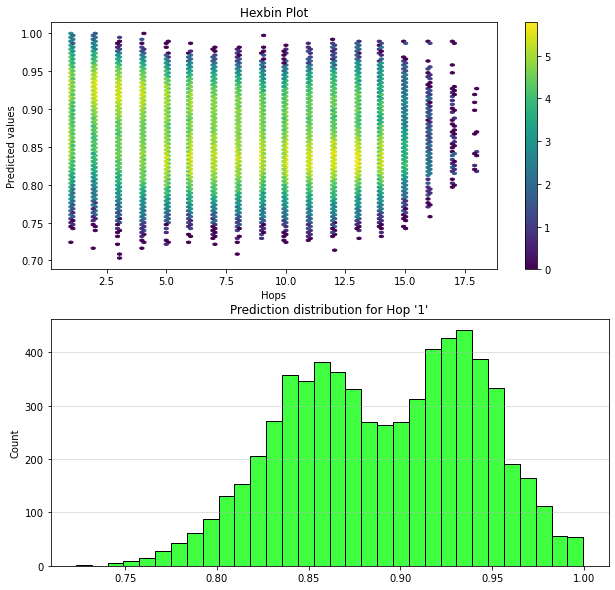

{'pseudo_precision': 0.1492639842983317,
 'pseudo_recall': 0.469372010492208,
 'pseudo_accuracy': 0.7541794346967026,
 'pseudo_f1': 0.226499385726518,
 'mse_list': [0.014555516869532154,
  0.16614475563572156,
  0.31423173397100596,
  0.3991476897603903,
  0.44636780072410587,
  0.48528606744367764,
  0.5155198198290237,
  0.5393662970859185,
  0.5559015026398945,
  0.5692247824644864,
  0.5818738761821228,
  0.5962153810208637,
  0.6046183913675834,
  0.6125147837318448,
  0.620233610897377,
  0.6354087684124152,
  0.6443498371072129,
  0.6422529153714085],
 'mae_list': [0.10922444762500821,
  0.4051902347835723,
  0.5586379739848798,
  0.6298477527620013,
  0.6664455727685432,
  0.6951314230651248,
  0.7166456077052649,
  0.7331412741421884,
  0.7444110167754661,
  0.7533314925655443,
  0.7616337042095103,
  0.7708908520357111,
  0.7763795167204826,
  0.7815140940660668,
  0.7864118342630053,
  0.7958453108304702,
  0.8015143034421428,
  0.8005798463192251],
 'Hop1 High': 46.93720104

In [11]:
just_cos = cosine_model(embeddings_dict)
test_model(just_cos, FE_inputs, test_balanced_loader, criterion)